In [19]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [20]:
model = YOLO('yolov8n.pt') #8n or 8m

In [21]:
vehicle_classes = {
    2: 'car',
    3: 'motorcycle',
    5: 'bus',
    7: 'truck'
}

In [22]:
def classify_traffic_level(total_vehicle_count):
    if total_vehicle_count <= 5:
        return "Low"
    elif total_vehicle_count <= 15:
        return "Medium"
    else:
        return "High"

In [23]:
import csv
from datetime import datetime
import os

def log_detection_to_csv(junction_name, vehicle_counts, total_count, traffic_level):
    filename = 'traffic_detection_log.csv'
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', newline='') as csvfile:
        fieldnames = ['Timestamp', 'Junction', 'Car', 'Motorcycle', 'Bus', 'Truck', 'Total', 'Traffic Level']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        if not file_exists:
            writer.writeheader()

        writer.writerow({
            'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'Junction': junction_name,
            'Car': vehicle_counts.get('car', 0),
            'Motorcycle': vehicle_counts.get('motorcycle', 0),
            'Bus': vehicle_counts.get('bus', 0),
            'Truck': vehicle_counts.get('truck', 0),
            'Total': total_count,
            'Traffic Level': traffic_level
        })

In [24]:
video_paths = [
    ('D:/TrafficFlow-AI/Demo Video/junction_1.mp4', 'Junction 1'),
    ('D:/TrafficFlow-AI/Demo Video/junction_2.mp4', 'Junction 2'),
    ('D:/TrafficFlow-AI/Demo Video/junction_3.mp4', 'Junction 3'),
    ('D:/TrafficFlow-AI/Demo Video/junction_4.mp4', 'Junction 4')
]

In [35]:
results = []

for path, junction_name in video_paths:
    print(f"\nProcessing {junction_name}...")
    cap = cv2.VideoCapture(path)
    
    if not cap.isOpened():
        print(f"Error loading {junction_name}")
        results.append(("Error", None))
        continue

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Frame error in {junction_name}")
        results.append(("Error", None))
        continue

    detection = model(frame)
    boxes = detection[0].boxes
    vehicle_counts = {}

    for box in boxes:
        cls_id = int(box.cls)
        if cls_id in vehicle_classes:
            label = vehicle_classes[cls_id]
            vehicle_counts[label] = vehicle_counts.get(label, 0) + 1

    total_count = sum(vehicle_counts.values())
    level = classify_traffic_level(total_count)

    # Log to CSV
    log_detection_to_csv(junction_name, vehicle_counts, total_count, level)

    # Annotate frame
    annotated = detection[0].plot()
    cv2.putText(annotated, f"{junction_name} - {level}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 3)

    results.append((level, annotated))


Processing Junction 1...

0: 384x640 9 cars, 2 trucks, 1 traffic light, 166.4ms
Speed: 2.9ms preprocess, 166.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

Processing Junction 2...

0: 384x640 20 cars, 3 buss, 3 trucks, 182.2ms
Speed: 4.1ms preprocess, 182.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

Processing Junction 3...

0: 384x640 12 persons, 7 cars, 3 trucks, 1 traffic light, 180.9ms
Speed: 2.9ms preprocess, 180.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

Processing Junction 4...

0: 640x384 10 cars, 1 bus, 2 trucks, 326.5ms
Speed: 2.7ms preprocess, 326.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


In [31]:
traffic_levels = [level for level, annotated in results]
print(traffic_levels)

['Medium', 'High', 'Medium', 'Medium']


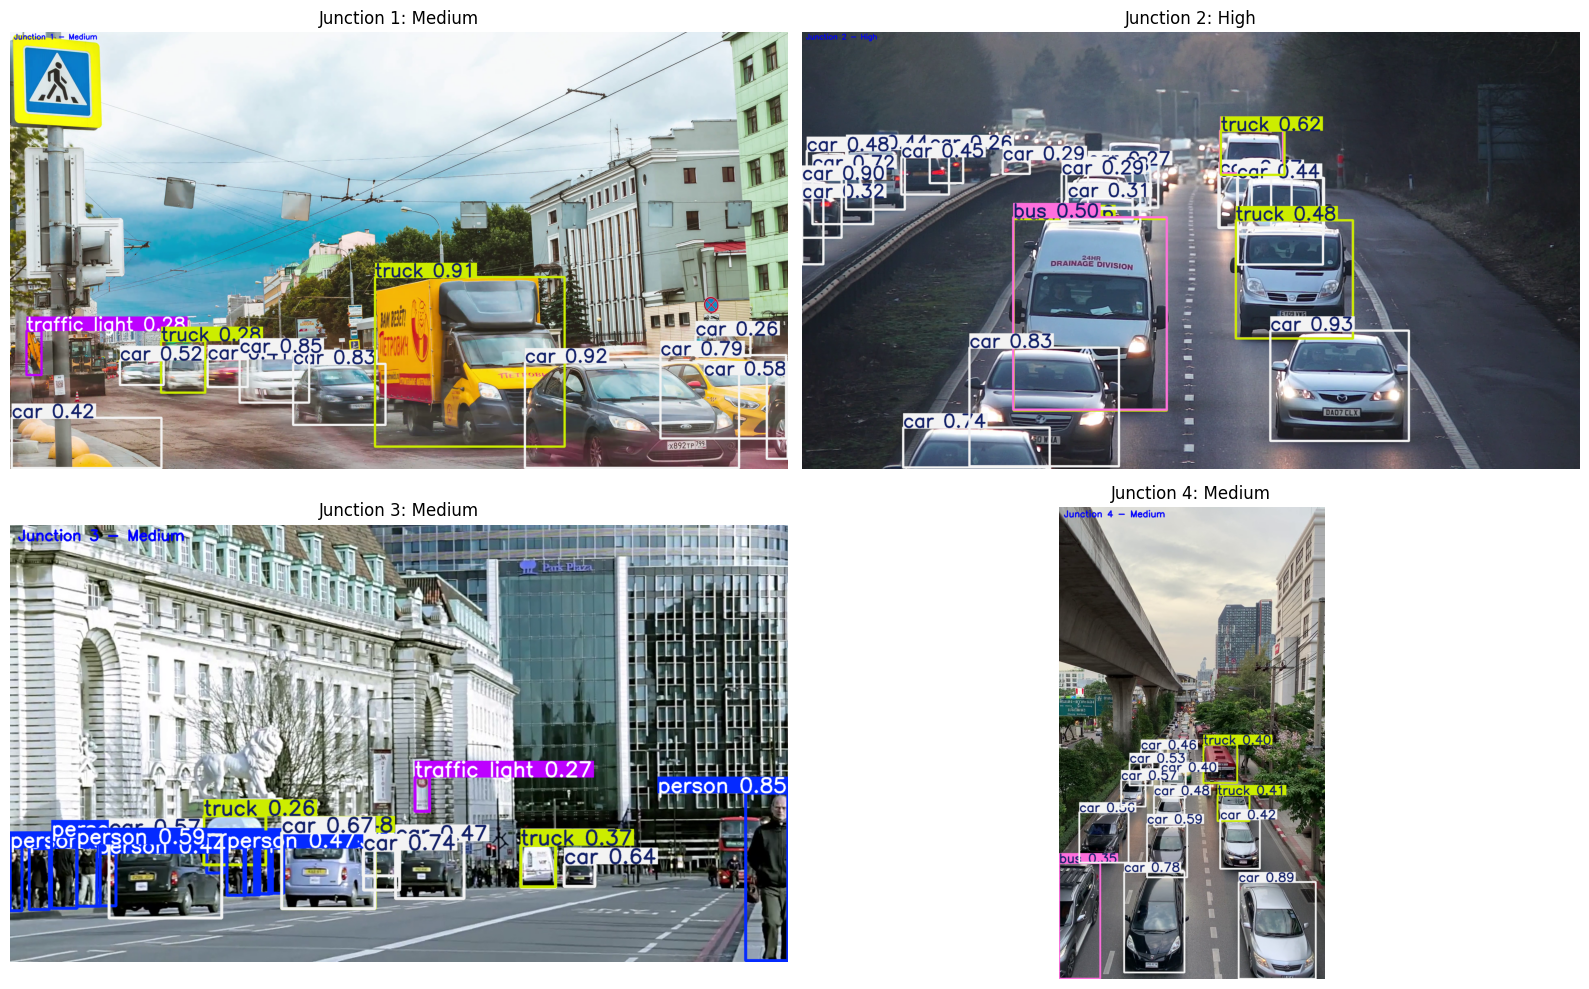

In [28]:
plt.figure(figsize=(16, 10))
for i, (level, img) in enumerate(results):
    if img is not None:
        plt.subplot(2, 2, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Junction {i+1}: {level}")
        plt.axis('off')
plt.tight_layout()
plt.show()